In [25]:
import pandas as pd
import numpy as np
import requests
import os
import datetime as dt
from datetime import datetime
import time


In [26]:
start_date = datetime(2017,4,1).date()
end_date = datetime(2022,4,30).date()
start_date_test = datetime(2022,5,1).date()
end_date_test = datetime(2022,5,30).date()
print(start_date)

2017-04-01


In [30]:
# fetch stock data
# url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAL&outputsize=full&datatype=json&apikey=I0D6SD0JRFHWY0JN"
# api_response = requests.get(url)

# js=api_response.json()
# js_info, header = api_response.json()
# #Convert to pandas dataframe
# print(type(js[header]))
# df = pd.DataFrame.from_dict(js[header], orient='index', dtype=np.float)

# df.index = df.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))

# # 生成完整的日期序列
# pdates = pd.date_range(start=start_date-dt.timedelta(days = 5), end=end_date_test+-dt.timedelta(days = 5))
# pdates
# df = df.reindex(pdates, fill_value=np.nan)


# df.to_csv('stock_dataset.csv', index=True, header=True, index_label='datetime')

df = pd.read_csv('stock_dataset.csv')
df
df = df.drop(columns=['1. open','2. high','3. low', '5. volume'])
df
df.columns=['datetime','stock']
df = df.set_index('datetime')
df.index = df.index.map(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df

,stock
datetime,
2017-03-27,41.74
2017-03-28,42.60
2017-03-29,41.96
2017-03-30,42.54
2017-03-31,42.30
...,...
2022-05-21,NaN
2022-05-22,NaN
2022-05-23,16.75


In [24]:
# interpolation
# df_ = df.interpolate(method='linear',limit_direction='both',axis=0)
# df_.tail(20)

In [31]:

df.columns
df = df.loc[start_date:end_date,:]



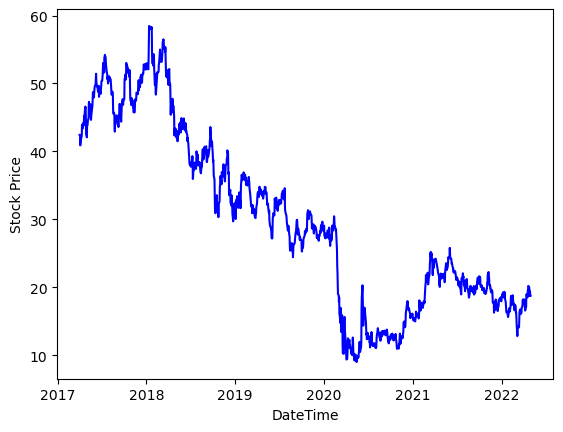

In [37]:
import matplotlib.pyplot as plt
#线性插值让图变连续
df_ = df.interpolate(method='linear',limit_direction='both',axis=0)
plt.plot(df_, linestyle='-', marker='',  c='b')

plt.xlabel('DateTime')
plt.ylabel('Stock Price')

plt.show()

In [35]:
coordinates = {'ATL':[33.63, -84.42], 'DFW':[32.89, -97.04], 'DEN':[39.85, -104.67], 'ORD':[41.97, -87.90], 'LAX':[33.94, -118.42]}

In [45]:
from meteostat import Point, Daily,  Stations

# Set time period
start = datetime(2017, 4, 1)
end = datetime(2022, 4, 30)
# start = datetime.fromtimestamp(start_date)
# end = datetime.fromtimestamp(end_date)
print(type(start), type(datetime.fromtimestamp(start_date)))
dataframe_list = []

for i,coordinate in coordinates.items():
    stations = Stations()
    stations = stations.nearby(coordinate[0],coordinate[1])
    stations = stations.inventory('daily', True)
    station = stations.fetch(1)
    data = Daily(station, start, end)
    data = data.fetch()
    data = data.drop(columns = ['tmin', 'tmax', 'wdir', 'wpgt', 'pres', 'tsun'])
    
    def rename_map(x):
        return i + '_' + x
    
    data = data.rename(columns=rename_map)
    dataframe_list.append(data)
#     print(data.columns)
    
df = pd.concat(dataframe_list)
df.index

TypeError: an integer is required (got type datetime.date)